In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Описание датасета

- `visit_number` — порядковый номер визита клиента;  
- `utm_source` — источник трафика;  
- `utm_medium` — тип привлечения;  
- `utm_campaign` — рекламная кампания;  
- `utm_adcontent` — содержание объявления;  
- `utm_keyword` — ключевое слово;  
- `device_category` — тип устройства;  
- `device_os` — ОС устройства;  
- `device_brand` — марка устройства;  
- `device_browser` — браузер;  
- `geo_country` — страна;  
- `geo_city` — город;  
- `event_value` — ценность события;  
- `number_of_hits` — количество хитов в сессии;  
- `auto_brand` — марка автомобиля;  
- `auto_model` — модель автомобиля;  
- `screen_size` — размер экрана (в условных единицах);    
- `visit_month` — месяц визита;  
- `visit_day` — день визита;  
- `visit_hour` — час визита;  
- `visit_weekday` — день недели визита;  
- `visit_daytime` — время суток визита;  
- `visit_season` — сезон визита;  
- `traffic` — тип трафика (organic / non-organic);  
- `social_ad` — наличие соц. рекламы (флаг).  

## Feature engineering

In [2]:
df = pd.read_pickle("data/ga_sessions_clean.pkl")
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_value,auto_brand,auto_model
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,android,huawei,360x720,chrome,russia,zlatoust,0.0,unknown_brand,unknown_model
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,1900-01-01 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,android,samsung,385x854,samsung,russia,moscow,0.0,unknown_brand,unknown_model
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,1900-01-01 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,android,huawei,360x720,chrome,russia,krasnoyarsk,0.0,volkswagen,polo
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,1900-01-01 05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,NOBKLgtuvqYWkXQHeYWM,unknown_keyword,mobile,android,xiaomi,393x786,chrome,russia,moscow,0.0,unknown_brand,unknown_model
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,1900-01-01 05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,unknown_adcontent,unknown_keyword,mobile,android,xiaomi,393x786,chrome,russia,moscow,0.0,unknown_brand,unknown_model


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 20 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_date                datetime64[ns]
 3   visit_time                datetime64[ns]
 4   visit_number              int64         
 5   utm_source                object        
 6   utm_medium                object        
 7   utm_campaign              object        
 8   utm_adcontent             object        
 9   utm_keyword               object        
 10  device_category           object        
 11  device_os                 object        
 12  device_brand              object        
 13  device_screen_resolution  object        
 14  device_browser            object        
 15  geo_country               object        
 16  geo_city                  object        
 17  event_va

In [4]:
#Функция вычисления конверсии
def CR(df, group_col):
    cr = df.groupby(group_col)['event_value'].mean()
    return cr

In [5]:
# Разбиение visit number на бины, создание признака visit_nuber_bins
# Биннинг по диапазонам
bins = [0, 5, 10, 20, 50, 100, 200, 300, df.visit_number.max()]
labels = ["1-5", "6-10", "11-20", "21-50", "51-100", "101-200", "201-300", f"301-{df.visit_number.max()}"]

df["visit_number_bins"] = pd.cut(df["visit_number"], bins=bins, labels=labels, right=True)

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_17424\3740561075.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cr_visit_number_bins = df.groupby("visit_number_bins")["event_value"].mean()


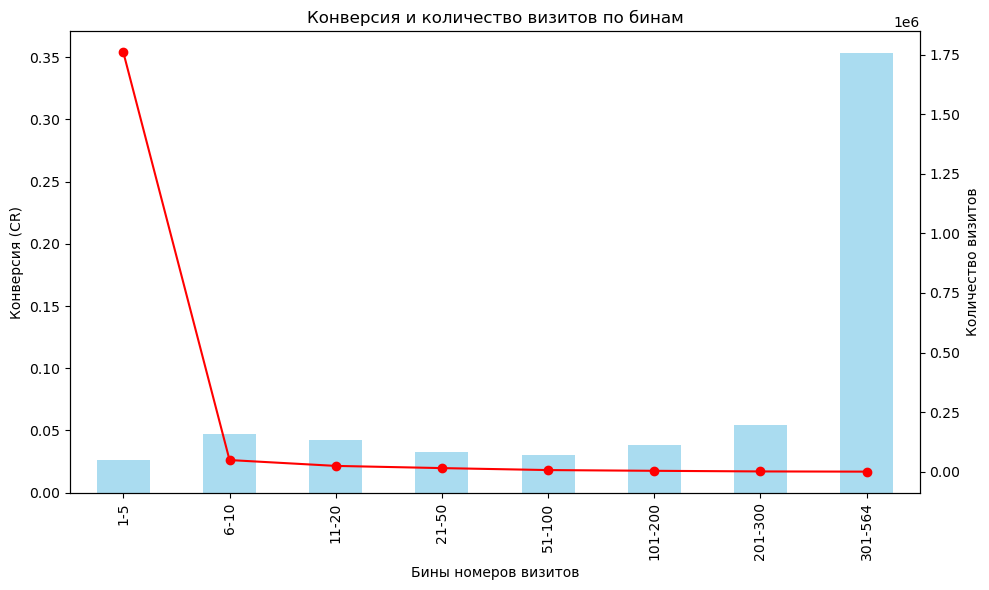

In [6]:
# Считаем конверсию по бинам
cr_visit_number_bins = df.groupby("visit_number_bins")["event_value"].mean()
#Считаем количество визитов в каждом бине
counts = df["visit_number_bins"].value_counts().sort_index()
# Строим график
fig, ax1 = plt.subplots(figsize=(10,6))

# Столбцы — CR
cr_visit_number_bins.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
ax1.set_ylabel("Конверсия (CR)")
ax1.set_xlabel("Бины номеров визитов")
ax1.set_title("Конверсия и количество визитов по бинам")

# Вторая ось — количество визитов
ax2 = ax1.twinx()
counts.plot(kind='line', ax=ax2, color='red', marker='o')
ax2.set_ylabel("Количество визитов")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Конверсия коррелирует с номером визита на сайт. Как видно, количество визитов на сайт примерно одинаковое у всех бинов со 2 по 8, при этом у последнего конверсия резко возрастает. То есть высокая конверсия вызвана не малым количеством данных, а тем что постоянные клиенты чаще совершают целевое действие. 

In [7]:
#Площадь экрана
df['screen_size']=df.device_screen_resolution.apply(lambda x: float(x.split('x')[0]) * float(x.split('x')[1]))

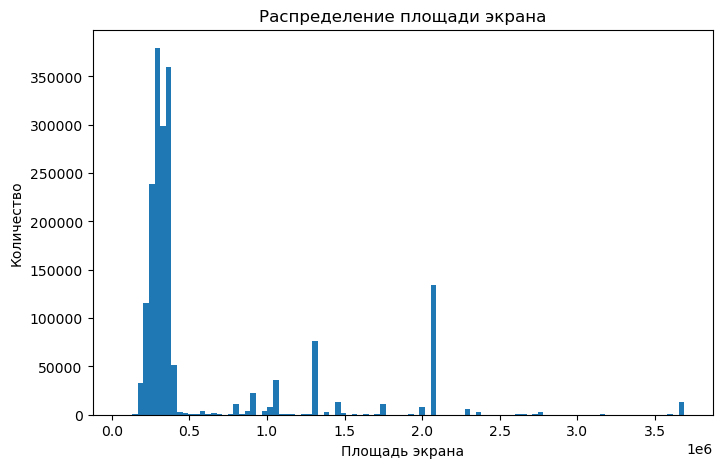

In [8]:
plt.figure(figsize=(8,5))
plt.hist(df['screen_size'], bins=100)
plt.xlabel("Площадь экрана")
plt.ylabel("Количество")
plt.title("Распределение площади экрана")
plt.show()

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_17424\133724748.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cr = df.groupby(group_col)['event_value'].mean()


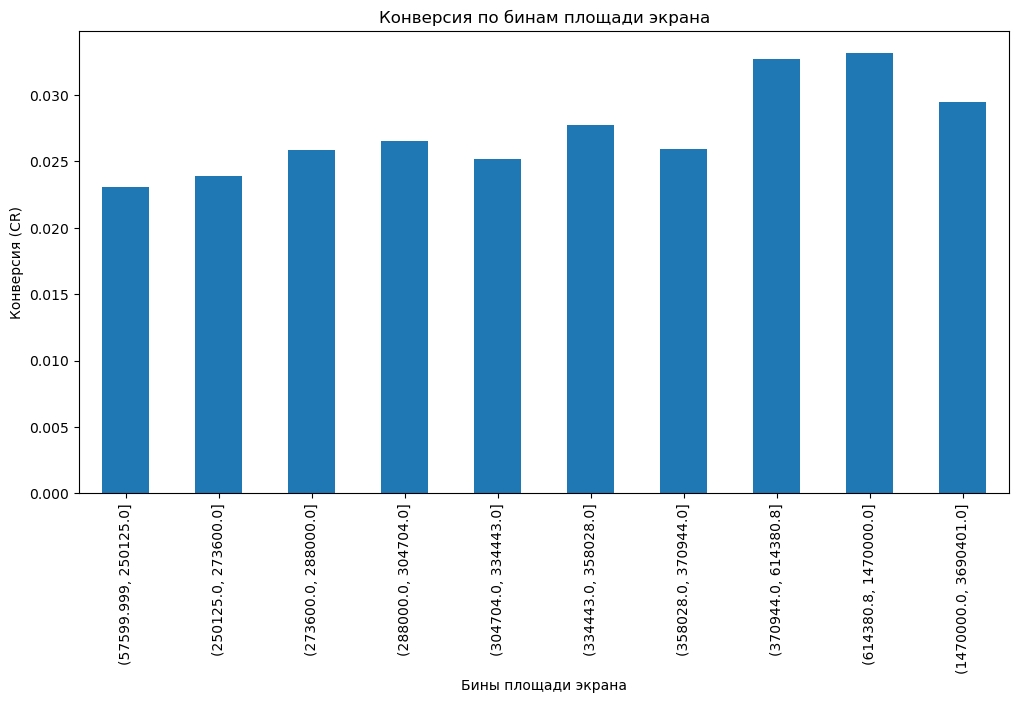

In [9]:
# Биннинг (например, 10 интервалов по квантилям)
df["screen_size_bin"] = pd.qcut(df.screen_size, q=10)

# Конверсия по бинам
cr_screen_size=CR(df, "screen_size_bin")

cr_screen_size.plot(kind="bar", figsize=(12,6))
plt.ylabel("Конверсия (CR)")
plt.xlabel("Бины площади экрана")
plt.title("Конверсия по бинам площади экрана")
plt.show()


Более высокая конверсия у больших экранов

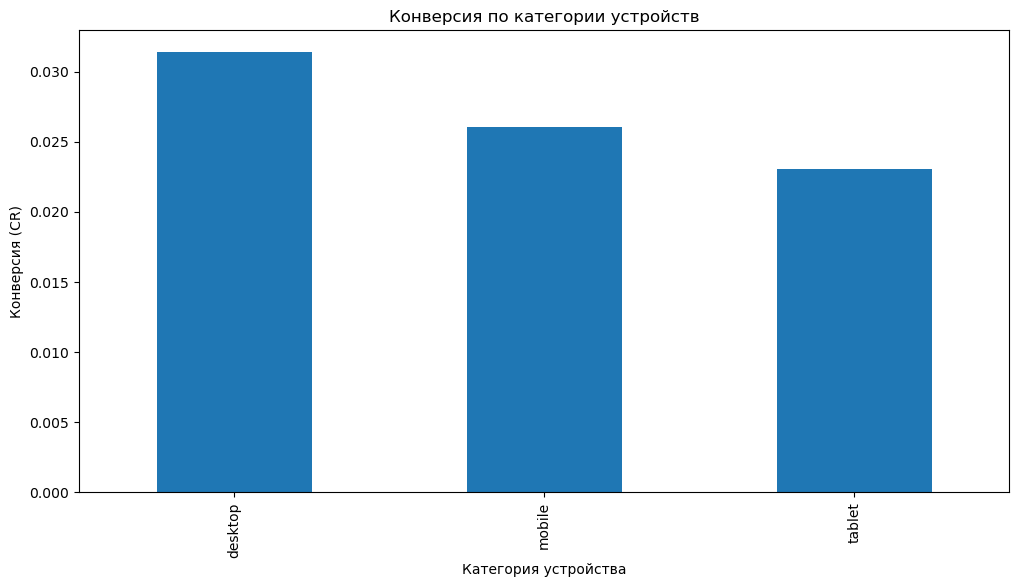

In [10]:
cr_device_categoty = CR(df, "device_category")

cr_device_categoty.plot(kind="bar", figsize=(12,6))
plt.ylabel("Конверсия (CR)")
plt.xlabel("Категория устройства")
plt.title("Конверсия по категории устройств")
plt.show()


Согласуется с прошлым выводом, конверсия выше у десктопных утройств

In [11]:
#Создание признаков по дате и времени
# Базовые временные фичи
df['visit_month']      = df['visit_date'].dt.month
df['visit_day']        = df['visit_date'].dt.day
df['visit_hour']       = df['visit_time'].dt.hour
df['visit_weekday']    = df['visit_date'].dt.dayofweek   # 0=понедельник, 6=воскресенье

# Время суток
def get_daytime(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

df['visit_daytime'] = df['visit_hour'].apply(get_daytime)

# Сезоны
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

df['visit_season'] = df['visit_month'].apply(get_season)

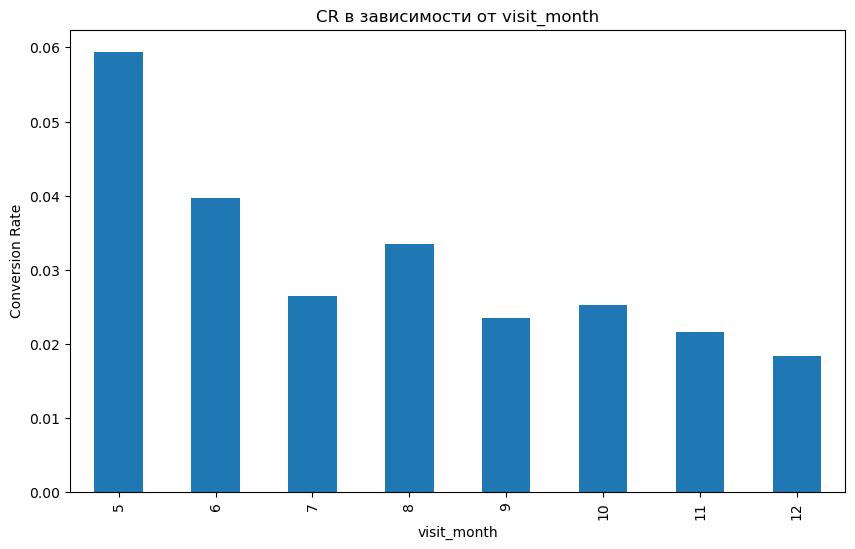

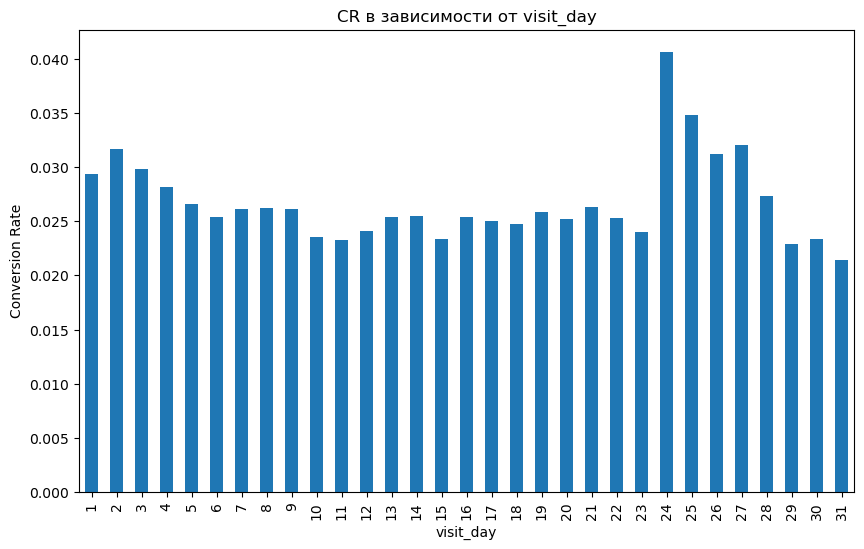

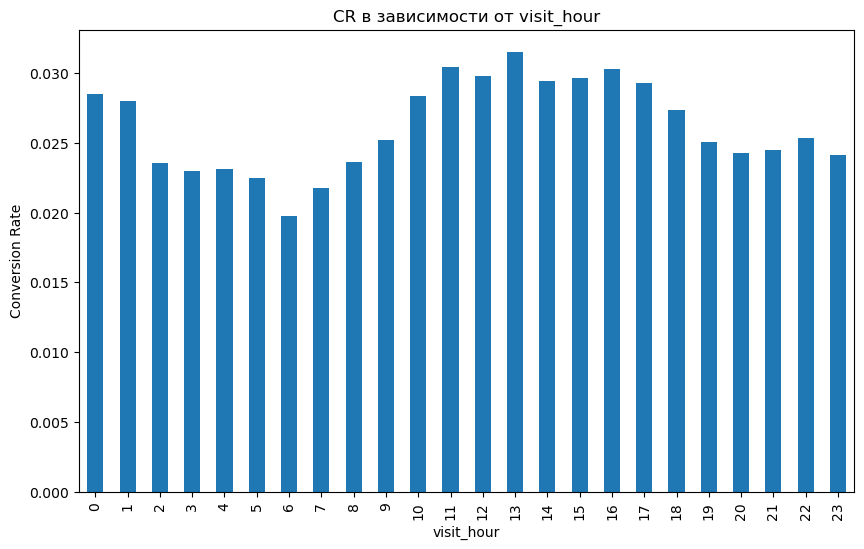

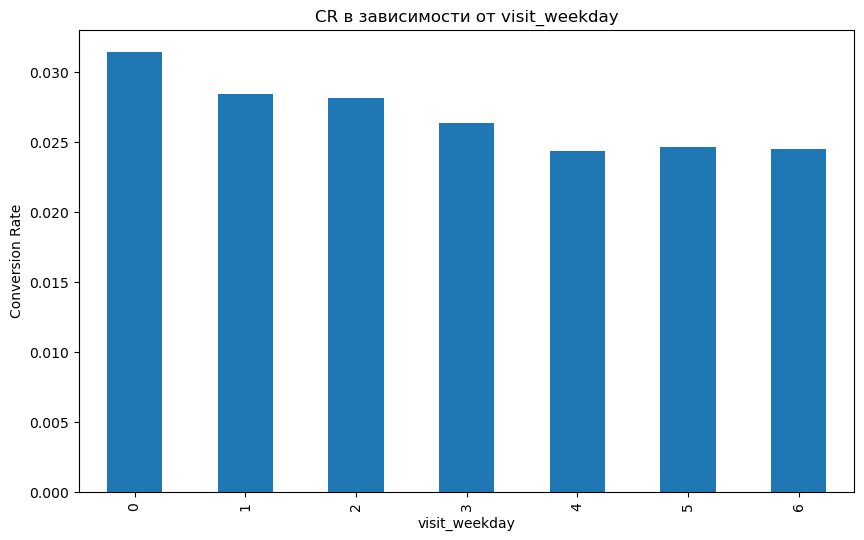

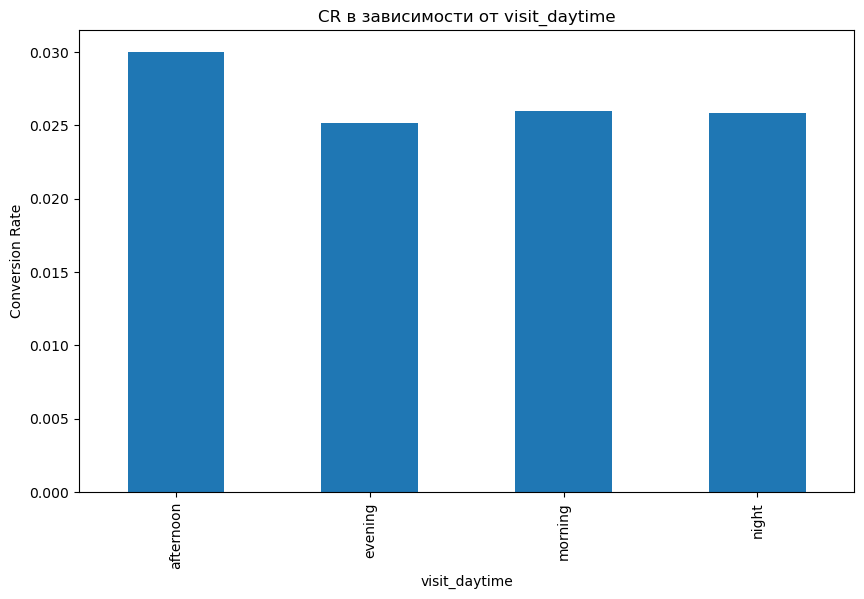

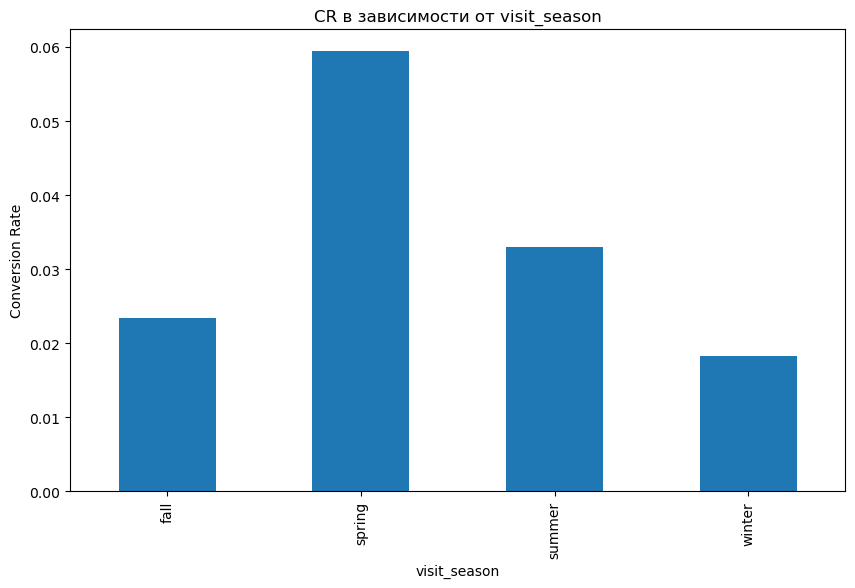

In [12]:
cr_daytime_features = {}

for i in ['visit_month','visit_day','visit_hour','visit_weekday','visit_daytime','visit_season']:
    cr_daytime_features[f"cr_{i}"] = CR(df, i)
    plt.figure(figsize=(10,6))
    cr_daytime_features[f"cr_{i}"].plot(kind="bar")
    plt.ylabel("Conversion Rate")
    plt.xlabel(i)
    plt.title(f"CR в зависимости от {i}")
    plt.show()

Высокая конверсия весной может быть связана с нехваткой данных. Данные только с мая по декабрь, поэтому данные для весны неполные.

In [13]:
#Реклама в социальных сетях
df['social_ad'] = df['utm_source'].apply(lambda x: 1 if x in ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                                                                        'ISrKoXQCxqqYvAZICvjs','IZEXUFLARCUMynmHNBGo', 
                                                                        'PlbkrSYoHuZBWfYjYnfw','gVRrcxiDQubJiljoTbGm'] 
                                         else 0)

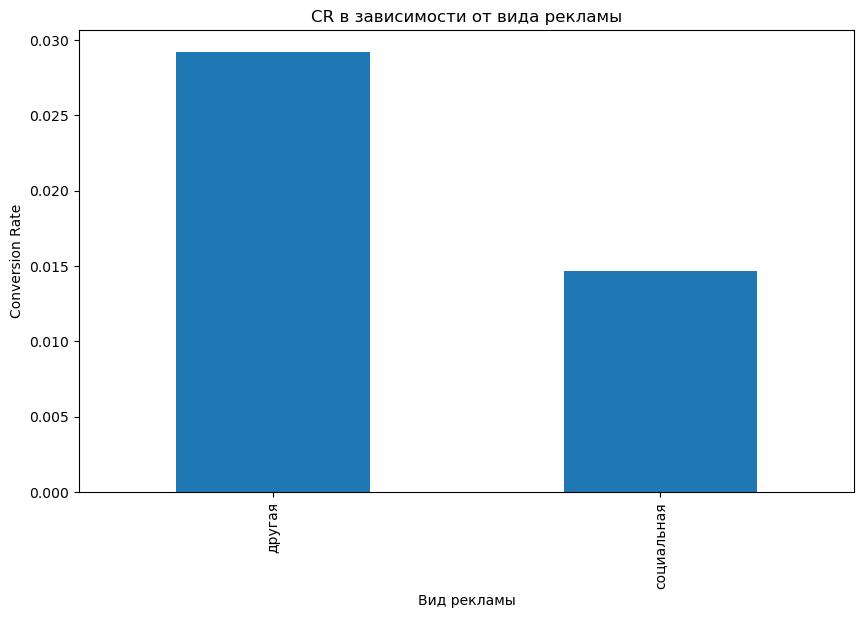

In [14]:
cr_social_ad = CR(df, 'social_ad')

plt.figure(figsize=(10,6))
ax = cr_social_ad.sort_values(ascending=False).plot(kind="bar")
# меняем подписи на оси X
ax.set_xticklabels(['социальная' if x == 1 else 'другая' for x in cr_social_ad.sort_index().index])
plt.ylabel("Conversion Rate")
plt.xlabel("Вид рекламы")
plt.title("CR в зависимости от вида рекламы")
plt.show()

Реклама в соц сетях реже приводит к совершению целевого действия, чем реклама из других источников

In [15]:
#Органический и платный трафик
df['organic_traffic'] = df['utm_medium'].apply(lambda x: 1 if x in ['organic', 'referral', '(none)'] else 0)

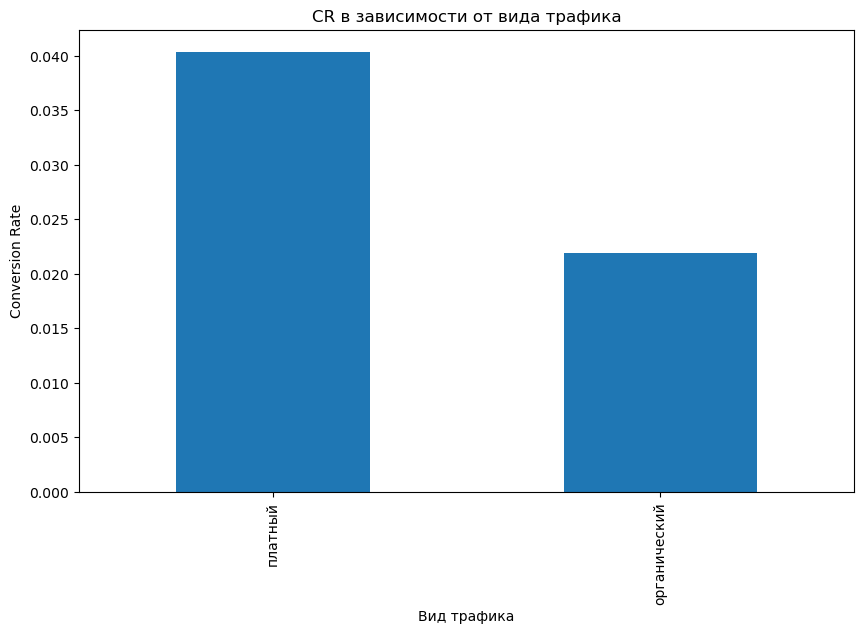

In [16]:
cr_traffic = CR(df, 'organic_traffic')

plt.figure(figsize=(10,6))
ax = cr_traffic.sort_values(ascending=False).plot(kind="bar")
# меняем подписи на оси X
ax.set_xticklabels(['органический' if x == 1 else 'платный' for x in cr_traffic.sort_index().index])
plt.ylabel("Conversion Rate")
plt.xlabel("Вид трафика")
plt.title("CR в зависимости от вида трафика")
plt.show()

In [17]:
df[['visit_hour','visit_day','visit_weekday', 'visit_month']] = df[['visit_hour','visit_day','visit_weekday', 'visit_month']].astype('int64')

In [18]:
#Счетчик уникальных значений по колонкам
df.select_dtypes(include=["object", "category"]).nunique()

session_id                  1860042
client_id                   1391717
utm_source                      293
utm_medium                       55
utm_campaign                    413
utm_adcontent                   287
utm_keyword                    1220
device_category                   3
device_os                        13
device_brand                    205
device_screen_resolution       4943
device_browser                   31
geo_country                     165
geo_city                       2519
auto_brand                       16
auto_model                       44
visit_number_bins                 8
screen_size_bin                  10
visit_daytime                     4
visit_season                      4
dtype: int64

Кодировка:
utm_source, utm_campaign, utm_adcontent, utm_keyword, device_brand, geo_city - FrequencyEncoder из-за большого числа уникальных значений
utm_medium, device_category, device_os, device_browser, geo_country, auto_brand, auto_model, visit_daytime, visit_season, traffic, social_ad - OneHotEncoder

In [19]:
pd.set_option("display.max_rows", None)

In [20]:
#Счетчик уникальных значений
df.utm_source.value_counts()

utm_source
ZpYIoDJMcFzVoPFsHGJL    578387
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
geDcueAOghDzHkGMmdOq      8680
ISrKoXQCxqqYvAZICvjs      8633
nSReTmyFtbSjlPrTKoaX      7285
SzZERoLMmrEUEhDaYcyN      6828
eLzNJHzPelJpEyBwMrKo      5386
IZEXUFLARCUMynmHNBGo      4421
iNFgfQPqHPBuvGCYtrQE      3532
oZCzWSykfixnjMPDNjSU      3143
gVRrcxiDQubJiljoTbGm      2767
nmfptFmSirEqNzAzqbXA      2243
GpAkIXsclxDGyILfNlrR      2116
TxKUcPpthBDPieTGmVhx      2093
ghoaGAksqhKomdFrxgyJ      1900
KgicpPxiEQfzPlPwQZJq      1761
nrKihqcWGIzDsOqljdAv      1670
BKeImrJuRDZcHiSSTdzm      1464
DnEUulZAecfGPvdtZBYS      14

In [22]:
correlation_source = df['utm_source_freq'].corr(df['event_value'])
print(f'Корреляция между source и event_value: {correlation_source}')

Корреляция между source и event_value: 0.00802116466733869


In [23]:
#Счетчик уникальных значений
df.utm_campaign.value_counts()

utm_campaign
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
unknown_campaign        219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15706
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12370
bJJuEXRheRIxXEaYIXqM     12232
YCKgTzTDywjcWyQudGch     12041
nSReTmyFtbSjlPrTKoaX     11611
QEejXfOCtOMFLZqIPApp     10172
vRLTQQKAsFQMxbcHGPhu      9461
jvsVVQVKRfBIqBDBuCkq      7950
eimRuUrNhZLAYcwRrNXu      7784
QdLfySaGXolfTBSNVfHn      7498
VBmazutCflYumtDHrQYe      7467
kVOrIKZFrEYGvixPclal      7062
MXqmDyetMTICSSitTjWV      7038
KgicpPxiEQfzPlPwQZJq      6939
PXQWdUxeUoXfoKzTBGpY      6901
JwYIveaHVpeeRZloQCfF      6548
jqlUOdZBNZYfInQVcZlS      6388
WiILFRDQbcHDHNvHzGpX      5793
IKQsApKuPmZqqmhieEgf      5607
GWZGdHKPgmZPNPwkJshU      

In [ ]:
#Группировка редких категорий, до 500 уникальных значений
counts = df["utm_medium"].value_counts()
rare_categories = counts[counts <= 500].index

df["utm_medium"] = df["utm_medium"].replace(rare_categories, "rare_campaign")

In [24]:
# Считаем частоты каждого campaign
campaign_freq_map = df['utm_campaign'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_campaign_freq'] = df['utm_campaign'].map(campaign_freq_map)

In [25]:
correlation_campaign = df['utm_campaign_freq'].corr(df['event_value'])
print(f'Корреляция между campaign и event_value: {correlation_campaign}')

Корреляция между campaign и event_value: 0.04892864939314997


In [26]:
#Счетчик уникальных значений
df.utm_adcontent.value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
unknown_adcontent        335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7319
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
XSkXBCPfnJjvxbfeewtd       4383
XKsYZiUFcdkUXQpoLKyS       4112
FkiRXDLOWtzVfvhEkhNo       2841
xnyHaukLtAvgViiZSyBC       2582
SAVVWaMghGnnvPOqMOIt       2501
guyNoEvzgofQvvwExGOq       2228
LcGIUNPUAmXtQJaDfFBR       2095
qhEmhjPXvwgEHdBikgEQ       1718
NhvfEqcSTGEZKxxvUZlj       1576
sYzBROYhjSDbFZCpzGyf       1538
DZYjhfIUfdqhfuTNUmjn       1460
EteMoEECGsaJeMnuvAZD       1412
eOWmIGTKVDPewucDtZXG       1042
twlfGCnyRPFtCeUKaust       1025
eEkLatVAYTkibdzPIyDi        992
ZKlsrASsGaoEHfwkdKjL      

In [27]:
# Считаем частоты каждого adcontent
adcontent_freq_map = df['utm_adcontent'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_adcontent_freq'] = df['utm_adcontent'].map(adcontent_freq_map)

In [28]:
correlation_adcontent = df['utm_adcontent_freq'].corr(df['event_value'])
print(f'Корреляция между adcontent и event_value: {correlation_adcontent}')

Корреляция между adcontent и event_value: 0.049562397460542085


In [29]:
#Счетчик уникальных значений
df.utm_keyword.value_counts()

utm_keyword
unknown_keyword         1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
hAmNSZmQkKQKAjZEGlgb      11297
UKNBOHebRIIsQRsjNKay      10946
IGUCNvHlhfHpROGclCit       7568
RkpOyeEPgcMBSDuHLQcj       6978
JajANoFxoqXfKRNBUhzx       6758
BmOOOIoWGHEfxEfoUezs       6602
ZNhSIPchlbnKwZWcsKzz       5661
pucKZkLDtpMDBTobJAJG       5391
RrhnkuoaqckNtJpAZDzH       5004
YQXPpoLsxnykCWKhGEmI       4874
DBHgBJHOdbPwsRDUbEgX       4472
tVtbIKrPSOvrXLCznVVe       3711
XEayFbemrPYbxFeNbxif       3695
MWLEpQPyjGkjHseVyeyQ       3156
fzbotReoFzSuckjwcpCs       2965
COtBsnAzfZyRVtvDlhnW       2785
tzIeQUUHahhBuEkJqDVp       2699
QYfbqJXuLdJGfOSFgZOs       2674
KCcEkEaKEtUilBVMoCAi       2637
ISrKoXQCxqqYvAZICvjs       2559
psjAUzFZVWWCuxgCrtmQ       2546
qxnAydKMtMSuafVrMzdC       2539
ObIWuFTMgFPUHNiFoOwb       2491
MBHgRPNeTcONuVFFXgmz       2476
oKjXDUsycmahkgMhGdAR       2387
qUcotcWimEOQiboVPcCx       2

In [30]:
# Считаем частоты каждого keyword
keyword_freq_map = df['utm_keyword'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['utm_keyword_freq'] = df['utm_keyword'].map(keyword_freq_map)

In [31]:
correlation_keyword = df['utm_keyword_freq'].corr(df['event_value'])
print(f'Корреляция между keyword и event_value: {correlation_keyword}')

Корреляция между keyword и event_value: 0.0367735377516191


In [32]:
#Счетчик уникальных значений
df.device_brand.value_counts()

device_brand
apple             551088
unknown_brand     384723
samsung           332194
xiaomi            288367
huawei            185853
realme             19058
oppo               13504
vivo               11740
oneplus             9965
asus                7929
nokia               7285
sony                6459
zte                 6365
google              5150
meizu               3750
lenovo              3148
blackview           2759
tecno               2654
lg                  2447
motorola            2357
bq                  1573
itel                1082
alcatel              968
doogee               876
oukitel              826
htc                  790
umidigi              661
ulefone              511
infinix              417
vsmart               368
leeco                344
blackberry           338
cubot                320
philips              299
mozilla              295
poco                 229
sharp                226
vertex               198
tp-link              194
dexp        

In [33]:
# Считаем частоты каждого brand
brand_freq_map = df['device_brand'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['device_brand_freq'] = df['device_brand'].map(brand_freq_map)

In [34]:
correlation_brand = df['device_brand_freq'].corr(df['event_value'])
print(f'Корреляция между device_brand и event_value: {correlation_brand}')

Корреляция между device_brand и event_value: 0.0058931397354677305


In [35]:
#Счетчик уникальных значений
df.geo_city.value_counts()

geo_city
moscow                          805329
saint petersburg                296789
unknown_city                     78465
yekaterinburg                    35788
krasnodar                        32243
kazan                            29531
samara                           24992
nizhny novgorod                  22227
ufa                              21679
novosibirsk                      21568
krasnoyarsk                      16346
chelyabinsk                      15951
tula                             15814
voronezh                         13908
rostov-on-don                    13886
irkutsk                          13532
grozny                           12742
balashikha                       12679
vladivostok                      12325
yaroslavl                         9833
sochi                             8972
tyumen                            8534
khimki                            7385
saratov                           7120
perm                              6293
vidnoye         

In [36]:
# Считаем частоты каждого city
city_freq_map = df['geo_city'].value_counts(normalize=True)  # normalize=True → доля, без него будут абсолютные значения
# Заменяем категорию на её частоту
df['geo_city_freq'] = df['geo_city'].map(city_freq_map)

In [37]:
correlation_city = df['geo_city_freq'].corr(df['event_value'])
print(f'Корреляция между geo_city и event_value: {correlation_city}')

Корреляция между geo_city и event_value: 0.010776795585859153


In [38]:
#Стандартизация числовых признаков
numerical_vars = ['visit_number','screen_size']
std_scaler = StandardScaler()
std_scaler.fit(df[numerical_vars])
numerical_scaled= std_scaler.transform(df[numerical_vars])
numerical_vars_std_scaled = []
for i in numerical_vars:
    numerical_vars_std_scaled.append(i + '_std')
df[numerical_vars_std_scaled] = numerical_scaled
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,social_ad,organic_traffic,utm_source_freq,utm_campaign_freq,utm_adcontent_freq,utm_keyword_freq,device_brand_freq,geo_city_freq,visit_number_std,screen_size_std
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0,0,0.310954,0.174213,0.097335,0.272477,0.099919,0.000120,-0.144796,-0.528110
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,1900-01-01 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,1,0,0.100105,0.132986,0.060790,0.004069,0.178595,0.432963,-0.144796,-0.414747
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,1900-01-01 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,0,0,0.310954,0.174213,0.097335,0.272477,0.099919,0.008788,-0.144796,-0.528110
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,1900-01-01 05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,NOBKLgtuvqYWkXQHeYWM,unknown_keyword,...,0,0,0.143198,0.118063,0.000394,0.581740,0.155033,0.432963,-0.144796,-0.447151
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,1900-01-01 05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,unknown_campaign,unknown_adcontent,unknown_keyword,...,0,0,0.143198,0.118063,0.180434,0.581740,0.155033,0.432963,-0.060259,-0.447151


In [39]:
#Циклическое представление дат
df["visit_day_sin"] = np.sin(2 * np.pi * df["visit_day"] / df["visit_day"].max())
df["visit_day_cos"] = np.cos(2 * np.pi * df["visit_day"] / df["visit_day"].max())

df["visit_hour_sin"] = np.sin(2 * np.pi * df["visit_hour"] / df["visit_hour"].max())
df["visit_hour_cos"] = np.cos(2 * np.pi * df["visit_hour"] / df["visit_hour"].max())

df["visit_weekday_sin"] = np.sin(2 * np.pi * df["visit_weekday"] / df["visit_weekday"].max())
df["visit_weekday_cos"] = np.cos(2 * np.pi * df["visit_weekday"] / df["visit_weekday"].max())

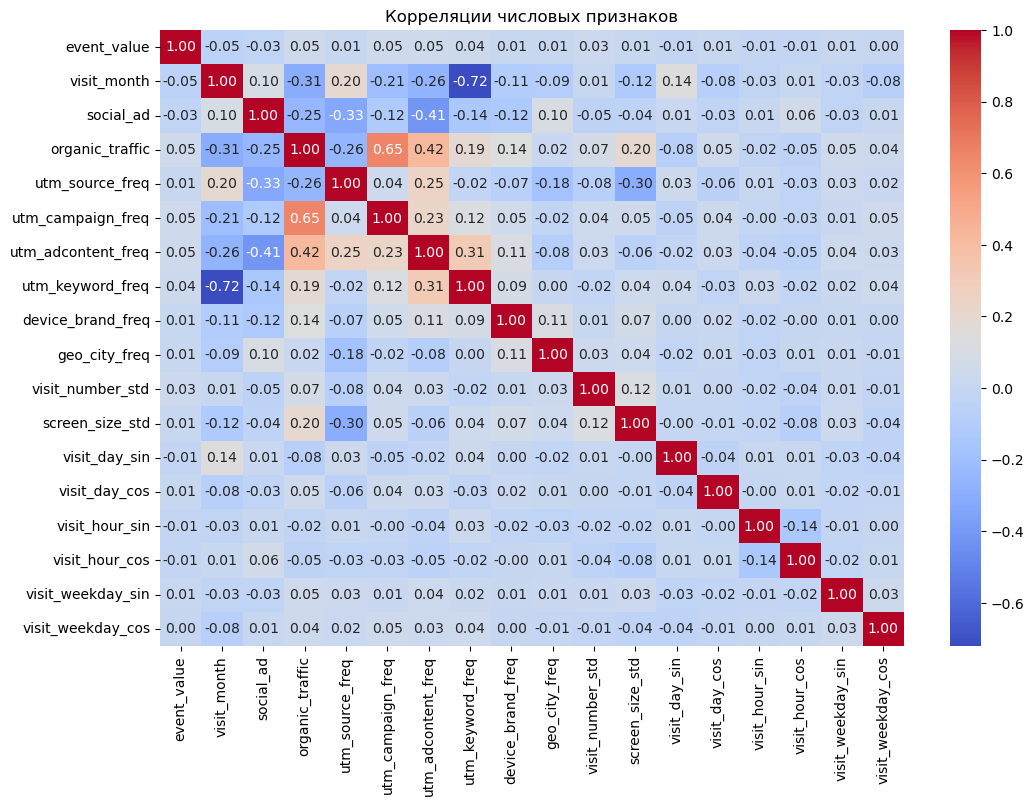

In [40]:
#Корреляция числовых признаков

# Берём только числовые фичи
num_cols = ['event_value', 'visit_month', 'social_ad', 'organic_traffic',
       'utm_source_freq', 'utm_campaign_freq', 'utm_adcontent_freq',
       'utm_keyword_freq', 'device_brand_freq', 'geo_city_freq',
       'visit_number_std', 'screen_size_std', 'visit_day_sin', 
        'visit_day_cos', 'visit_hour_sin', 'visit_hour_cos',
       'visit_weekday_sin', 'visit_weekday_cos']

plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляции числовых признаков")
plt.show()

Большинство корреляций низкие, т.е. нет сильных линейных зависимостей с целевым действием.

Объяснение заметных корреляций других признаков:
- traffic ~ utm_campaign_freq
Трафик зависит от рекламных кампаний, чем чаще встречается конкретная кампания, тем выше вероятность неорганического трафика.
- traffic ~ utm_adcontent_freq
Реклама и конкретные виды объявлений влияют на трафик
- utm_campaign_freq ~ utm_adcontent_freq
Кампании и объявления взаимосвязаны, внутри одной кампании используется ограниченный набор объявлений.
- utm_source_freq ~ utm_adcontent_freq
Разные источники редко делят один и тот же контент, то есть каналы чётко разделены по рекламным материалам.
- utm_source_freq ~ visit_month
Источники трафика зависят от месяца, может быть есть сезонные каналы.
- utm_keyword_freq ~ utm_adcontent_freq
Ключевые слова связаны с креативами, определённые слова используются в одних и тех же объявлениях.
- utm_keyword_freq ~ visit_month
Очень сильная отрицательная корреляция. Значит, ключевые слова сильно зависит от месяца, есть сезонность.


OneHotEncoder

In [41]:
#Счетчик уникальных значений
df.utm_medium.value_counts()

utm_medium
banner               552752
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
CPM                      40
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article                  17
nkp      

In [42]:
#Группировка редких категорий, до 500 уникальных значений
counts = df["utm_medium"].value_counts()
rare_categories = counts[counts <= 500].index

df["utm_medium"] = df["utm_medium"].replace(rare_categories, "rare_medium")

In [43]:
#Счетчик уникальных значений
df.utm_medium.value_counts()

utm_medium
banner             552752
cpc                434794
(none)             300575
cpm                242083
referral           152050
organic             63034
email               29240
push                28035
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
app                  2836
post                 2326
smm                  1985
outlook              1332
rare_medium          1280
clicks                934
blogger_header        771
Name: count, dtype: int64

In [44]:
#Счетчик уникальных значений
df.device_category.value_counts()

device_category
mobile     1474871
desktop     366863
tablet       18308
Name: count, dtype: int64

In [45]:
#Счетчик уникальных значений
df.device_os.value_counts()

device_os
android          933329
ios              551055
unknown_os       257237
windows           88307
macintosh         24863
linux              5120
chrome os            83
blackberry           27
tizen                 7
samsung               4
windows phone         4
firefox os            3
nokia                 3
Name: count, dtype: int64

In [46]:
#Оставляем только первое слово в названии браузера
df.device_os = df.device_os.str.split(' ').str[0]

In [47]:
#Счетчик уникальных значений
df.device_os.value_counts()

device_os
android       933329
ios           551055
unknown_os    257237
windows        88311
macintosh      24863
linux           5120
chrome            83
blackberry        27
tizen              7
samsung            4
firefox            3
nokia              3
Name: count, dtype: int64

In [48]:
#Счетчик уникальных значений
df.device_browser.value_counts()

device_browser
chrome        1013453
safari         548474
yabrowser      133311
android         55832
samsung         47309
opera           26862
firefox         16588
edge            16065
uc                871
instagram         396
mozilla           379
fban              269
mrchrome           77
puffin             45
internet           36
maxthon            31
vkclient            8
amazon              7
coc                 6
helloworld          6
seamonkey           4
iron                2
netfront            2
myapp               2
mttd                1
nokiax              1
nokia               1
phantom             1
musically           1
konqueror           1
threads             1
Name: count, dtype: int64

In [49]:
#Группировка редких категорий, до 1000 уникальных значений
counts = df["device_browser"].value_counts()
rare_categories = counts[counts <= 1000].index

df["device_browser"] = df["device_browser"].replace(rare_categories, "rare_device_browsers")

In [50]:
#Счетчик уникальных значений
df.device_browser.value_counts()

device_browser
chrome                  1013453
safari                   548474
yabrowser                133311
android                   55832
samsung                   47309
opera                     26862
firefox                   16588
edge                      16065
rare_device_browsers       2148
Name: count, dtype: int64

In [51]:
#Счетчик уникальных значений
df.geo_country.value_counts()

geo_country
russia                      1801711
united states                 11784
ukraine                        9012
ireland                        4034
belarus                        3636
sweden                         2694
kazakhstan                     2279
germany                        2232
turkey                         1953
netherlands                    1549
uzbekistan                     1523
united kingdom                 1462
kyrgyzstan                      974
georgia                         935
france                          790
cyprus                          765
armenia                         681
finland                         643
spain                           599
poland                          556
united arab emirates            473
israel                          429
tajikistan                      400
moldova                         385
latvia                          357
italy                           355
egypt                           330
azerbaijan      

In [52]:
#Группировка редких катгорий, до 300 уникальных значений
counts = df["geo_country"].value_counts()
rare_countries = counts[counts <= 300].index

df["geo_country"] = df["geo_country"].replace(rare_countries, "rare_countries")
df["geo_country"] = df["geo_country"].str.replace(' ', "_")

In [53]:
#Счетчик уникальных значений
df.geo_country.value_counts()

geo_country
russia                  1801711
united_states             11784
ukraine                    9012
rare_countries             6863
ireland                    4034
belarus                    3636
sweden                     2694
kazakhstan                 2279
germany                    2232
turkey                     1953
netherlands                1549
uzbekistan                 1523
united_kingdom             1462
kyrgyzstan                  974
georgia                     935
france                      790
cyprus                      765
armenia                     681
finland                     643
spain                       599
poland                      556
united_arab_emirates        473
israel                      429
tajikistan                  400
moldova                     385
latvia                      357
italy                       355
egypt                       330
azerbaijan                  328
greece                      310
Name: count, dtype: int64

In [54]:
#Счетчик уникальных значений
df.auto_brand.value_counts()

auto_brand
unknown_brand    1337370
skoda             171258
volkswagen         85933
kia                60168
renault            47199
toyota             28150
nissan             27909
lexus              19914
bmw                18633
haval              16656
volvo              13018
porsche            12371
audi                8080
mini                6678
peugeot             6100
hyundai              605
Name: count, dtype: int64

In [55]:
#Счетчик уникальных значений
df.auto_model.value_counts()

auto_model
unknown_model    1337370
rapid              93876
polo               65782
karoq              48960
qashqai            27909
rio                26413
duster             23941
logan              23213
octavia            21216
camry              18468
seltos             17508
jolion             16656
sorento            14426
s90                13018
rx                 10645
tiguan             10082
nx                  9269
cayenne             7306
kodiaq              7206
x3                  6981
hatch               6678
touareg             6381
traveller           6100
x5                  5431
911                 5041
fortuner            4894
a3                  4025
x6                  3849
alphard             3497
q5                  3150
teramont            3137
x7                  2372
corolla             1291
soul                 981
a4                   905
cerato               717
solaris              605
taos                 503
sportage             118
passat        

In [56]:
#Счетчик уникальных значений
df.visit_daytime.value_counts()

visit_daytime
afternoon    626216
evening      576344
morning      457324
night        200158
Name: count, dtype: int64

In [57]:
#Счетчик уникальных значений
df.visit_season.value_counts()

visit_season
fall      836869
summer    515869
winter    399102
spring    108202
Name: count, dtype: int64

In [58]:
ohe = OneHotEncoder(sparse_output = False) 

In [59]:
#Колонки для кодирования OneHot
cols = ['utm_medium','device_category', 'device_os', 'device_browser','geo_country',
        'auto_model','auto_brand','visit_daytime','visit_season']
# Обучаем и преобразуем
ohe_categories = ohe.fit_transform(df[cols])

In [60]:
# Делаем DataFrame с новыми колонками
ohe_df = pd.DataFrame(ohe_categories, columns=ohe.get_feature_names_out(cols), index=df.index)
# Склеиваем с исходным датафреймом
df = pd.concat([df, ohe_df], axis=1)

In [61]:
pd.set_option("display.max_columns", None)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_value,auto_brand,auto_model,visit_number_bins,screen_size,screen_size_bin,visit_month,visit_day,visit_hour,visit_weekday,visit_daytime,visit_season,social_ad,organic_traffic,utm_source_freq,utm_campaign_freq,utm_adcontent_freq,utm_keyword_freq,device_brand_freq,geo_city_freq,visit_number_std,screen_size_std,visit_day_sin,visit_day_cos,visit_hour_sin,visit_hour_cos,visit_weekday_sin,visit_weekday_cos,utm_medium_(none),utm_medium_app,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_clicks,utm_medium_cpa,utm_medium_cpc,utm_medium_cpm,utm_medium_cpv,utm_medium_email,utm_medium_organic,utm_medium_outlook,utm_medium_post,utm_medium_push,utm_medium_rare_medium,utm_medium_referral,utm_medium_smartbanner,utm_medium_smm,utm_medium_stories,utm_medium_tg,device_category_desktop,device_category_mobile,device_category_tablet,device_os_android,device_os_blackberry,device_os_chrome,device_os_firefox,device_os_ios,device_os_linux,device_os_macintosh,device_os_nokia,device_os_samsung,device_os_tizen,device_os_unknown_os,device_os_windows,device_browser_android,device_browser_chrome,device_browser_edge,device_browser_firefox,device_browser_opera,device_browser_rare_device_browsers,device_browser_safari,device_browser_samsung,device_browser_yabrowser,geo_country_armenia,geo_country_azerbaijan,geo_country_belarus,geo_country_cyprus,geo_country_egypt,geo_country_finland,geo_country_france,geo_country_georgia,geo_country_germany,geo_country_greece,geo_country_ireland,geo_country_israel,geo_country_italy,geo_country_kazakhstan,geo_country_kyrgyzstan,geo_country_latvia,geo_country_moldova,geo_country_netherlands,geo_country_poland,geo_country_rare_countries,geo_country_russia,geo_country_spain,geo_country_sweden,geo_country_tajikistan,geo_country_turkey,geo_country_ukraine,geo_country_united_arab_emirates,geo_country_united_kingdom,geo_country_united_states,geo_country_uzbekistan,auto_model_911,auto_model_a3,auto_model_a4,auto_model_alphard,auto_model_arkana,auto_model_camry,auto_model_cayenne,auto_model_cerato,auto_model_corolla,auto_model_duster,auto_model_fortuner,auto_model_hatch,auto_model_jolion,auto_model_k5,auto_model_karoq,auto_model_kodiaq,auto_model_logan,auto_model_macan,auto_model_nx,auto_model_octavia,auto_model_panamera,auto_model_passat,auto_model_polo,auto_model_q5,auto_model_qashqai,auto_model_rapid,auto_model_rio,auto_model_rx,auto_model_s90,auto_model_seltos,auto_model_solaris,auto_model_sorento,auto_model_soul,auto_model_sportage,auto_model_taos,auto_model_teramont,auto_model_tiguan,auto_model_touareg,auto_model_traveller,auto_model_unknown_model,auto_model_x3,auto_model_x5,auto_model_x6,auto_model_x7,auto_brand_audi,auto_brand_bmw,auto_brand_haval,auto_brand_hyundai,auto_brand_kia,auto_brand_lexus,auto_brand_mini,auto_brand_nissan,auto_brand_peugeot,auto_brand_porsche,auto_brand_renault,auto_brand_skoda,auto_brand_toyota,auto_brand_unknown_brand,auto_brand_volkswagen,auto_brand_volvo,visit_daytime_afternoon,visit_daytime_evening,visit_daytime_morning,visit_daytime_night,visit_season_fall,visit_season_spring,visit_season_summer,visit_season_winter
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1900-01-01 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,android,huawei,360x720,chrome,russia,zlatoust,0.0,unknown_brand,unknown_model,1-5,259200.0,"(250125.0, 273600.0]",11,24,14,2,afternoon,fall,0,0,0.310954,0.174213,0.097335,0.272477,0.099919,0.000120,-0.144796,-0.528110,-0.988468,0.151428,-0.631088,-0.775711,8.660254e-01,-0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [62]:
#Колонки на удаление, удаляем вспомогательные и сырые колонки
columns_to_drop = ['session_id','client_id','visit_date','visit_time','visit_number', 'utm_source',
                   'utm_medium','utm_campaign','utm_adcontent','utm_keyword', 'device_category', 'device_os',
                   'device_brand','device_screen_resolution','device_browser', 'geo_country','geo_city',
                   'auto_brand', 'auto_model','visit_number_bins','screen_size', 'screen_size_bin', 
                   'visit_day','visit_hour','visit_weekday', 'visit_daytime', 'visit_season']
df = df.drop(columns_to_drop, axis = 1)

In [63]:
pd.set_option("display.max_columns", None)
df.head()

,event_value,visit_month,social_ad,organic_traffic,utm_source_freq,utm_campaign_freq,utm_adcontent_freq,utm_keyword_freq,device_brand_freq,geo_city_freq,visit_number_std,screen_size_std,visit_day_sin,visit_day_cos,visit_hour_sin,visit_hour_cos,visit_weekday_sin,visit_weekday_cos,utm_medium_(none),utm_medium_app,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_clicks,utm_medium_cpa,utm_medium_cpc,utm_medium_cpm,utm_medium_cpv,utm_medium_email,utm_medium_organic,utm_medium_outlook,utm_medium_post,utm_medium_push,utm_medium_rare_medium,utm_medium_referral,utm_medium_smartbanner,utm_medium_smm,utm_medium_stories,utm_medium_tg,device_category_desktop,device_category_mobile,device_category_tablet,device_os_android,device_os_blackberry,device_os_chrome,device_os_firefox,device_os_ios,device_os_linux,device_os_macintosh,device_os_nokia,device_os_samsung,device_os_tizen,device_os_unknown_os,device_os_windows,device_browser_android,device_browser_chrome,device_browser_edge,device_browser_firefox,device_browser_opera,device_browser_rare_device_browsers,device_browser_safari,device_browser_samsung,device_browser_yabrowser,geo_country_armenia,geo_country_azerbaijan,geo_country_belarus,geo_country_cyprus,geo_country_egypt,geo_country_finland,geo_country_france,geo_country_georgia,geo_country_germany,geo_country_greece,geo_country_ireland,geo_country_israel,geo_country_italy,geo_country_kazakhstan,geo_country_kyrgyzstan,geo_country_latvia,geo_country_moldova,geo_country_netherlands,geo_country_poland,geo_country_rare_countries,geo_country_russia,geo_country_spain,geo_country_sweden,geo_country_tajikistan,geo_country_turkey,geo_country_ukraine,geo_country_united_arab_emirates,geo_country_united_kingdom,geo_country_united_states,geo_country_uzbekistan,auto_model_911,auto_model_a3,auto_model_a4,auto_model_alphard,auto_model_arkana,auto_model_camry,auto_model_cayenne,auto_model_cerato,auto_model_corolla,auto_model_duster,auto_model_fortuner,auto_model_hatch,auto_model_jolion,auto_model_k5,auto_model_karoq,auto_model_kodiaq,auto_model_logan,auto_model_macan,auto_model_nx,auto_model_octavia,auto_model_panamera,auto_model_passat,auto_model_polo,auto_model_q5,auto_model_qashqai,auto_model_rapid,auto_model_rio,auto_model_rx,auto_model_s90,auto_model_seltos,auto_model_solaris,auto_model_sorento,auto_model_soul,auto_model_sportage,auto_model_taos,auto_model_teramont,auto_model_tiguan,auto_model_touareg,auto_model_traveller,auto_model_unknown_model,auto_model_x3,auto_model_x5,auto_model_x6,auto_model_x7,auto_brand_audi,auto_brand_bmw,auto_brand_haval,auto_brand_hyundai,auto_brand_kia,auto_brand_lexus,auto_brand_mini,auto_brand_nissan,auto_brand_peugeot,auto_brand_porsche,auto_brand_renault,auto_brand_skoda,auto_brand_toyota,auto_brand_unknown_brand,auto_brand_volkswagen,auto_brand_volvo,visit_daytime_afternoon,visit_daytime_evening,visit_daytime_morning,visit_daytime_night,visit_season_fall,visit_season_spring,visit_season_summer,visit_season_winter
0,0.0,11,0,0,0.310954,0.174213,0.097335,0.272477,0.099919,0.000120,-0.144796,-0.528110,-0.988468,0.151428,-0.631088,-0.775711,8.660254e-01,-0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,11,1,0,0.100105,0.132986,0.060790,0.004069,0.178595,0.432963,-0.144796,-0.414747,0.299363,-0.954139,0.816970,-0.576680,-2.449294e-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [64]:
#Сохранение датафрейма
df.to_pickle("data/ga_sessions_prepared.pkl")